<a href="https://colab.research.google.com/github/nikitazhuikov/ML-projects/blob/main/TitanikSklearnML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [24]:
import tpot

ModuleNotFoundError: No module named 'tpot'

In [3]:
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

In [6]:
titanic_df = pd.read_csv('Titanic-Dataset.csv', usecols=['Pclass', 'Survived', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'])
embarked_mode = titanic_df['Embarked'].mode()[0]
titanic_df['Embarked'].fillna(embarked_mode, inplace=True)
age_median = titanic_df['Age'].median()
titanic_df['Age'].fillna(age_median, inplace=True)
titanic_df['Sex'] = pd.factorize(titanic_df['Sex'])[0]
# Создание FamilySize
titanic_df['FamilySize'] = titanic_df['SibSp'] + titanic_df['Parch'] + 1
# Создание IsAlone
titanic_df['IsAlone'] = (titanic_df['FamilySize'] == 1).astype(int)
titanic_df = pd.get_dummies(titanic_df, columns=['Embarked', 'Pclass'], drop_first=True)
numerical_cols = titanic_df[['Age', 'Fare', 'FamilySize']].columns
titanic_df = titanic_df.drop(['SibSp', 'Parch'], axis=1)

In [7]:
# нормализация
titanic_df[numerical_cols] = StandardScaler().fit_transform(titanic_df[numerical_cols])

In [8]:
print(titanic_df.head())

   Survived  Sex       Age      Fare  FamilySize  IsAlone  Embarked_Q   
0         0    0 -0.565736 -0.502445    0.059160        0       False  \
1         1    1  0.663861  0.786845    0.059160        0       False   
2         1    1 -0.258337 -0.488854   -0.560975        1       False   
3         1    1  0.433312  0.420730    0.059160        0       False   
4         0    0  0.433312 -0.486337   -0.560975        1       False   

   Embarked_S  Pclass_2  Pclass_3  
0        True     False      True  
1       False     False     False  
2        True     False      True  
3        True     False     False  
4        True     False      True  


In [9]:
x = titanic_df.drop('Survived', axis = 1)

In [10]:
y = titanic_df['Survived']

In [11]:
x_train, x_test, y_train,  y_test = train_test_split(x, y, test_size=0.3)
# x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)

In [12]:
mdl = LogisticRegression(max_iter=100)
mdl.fit(x_train, y_train)
y_pred = mdl.predict(x_test)
TP = ((y_test == 1) & (y_pred == 1)).sum()
TN = ((y_test == 0) & (y_pred == 0)).sum()
FP = ((y_test == 0) & (y_pred == 1)).sum()
FN = ((y_test == 1) & (y_pred == 0)).sum()

In [13]:
accuracy = (TP + TN)/(TP + TN + FP + FN)
precision = TP  / (TP + FP)
recall = TP / (TP + FP)
sensitivity = TP / (TP + FN)

In [14]:
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)
print('sensitivity:', sensitivity)

accuracy: 0.7723880597014925
precision: 0.7052631578947368
recall: 0.7052631578947368
sensitivity: 0.67


In [15]:
# считаем ROC-AUC
y_pred_proba = mdl.predict_proba(x_test)[:, 1]

In [16]:
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Probability': y_pred_proba
})
comparison_df = comparison_df.sort_values('Probability', ascending=False)
comparison_df

,Actual,Predicted,Probability
700,1,1,0.980041
329,1,1,0.971109
31,1,1,0.964177
849,1,1,0.958448
9,1,1,0.954751
...,...,...,...
280,0,0,0.033062
116,0,0,0.026944
683,0,0,0.024276
360,0,0,0.018188


In [17]:
P = comparison_df['Actual'].value_counts()[1]
N = comparison_df['Actual'].value_counts()[0]

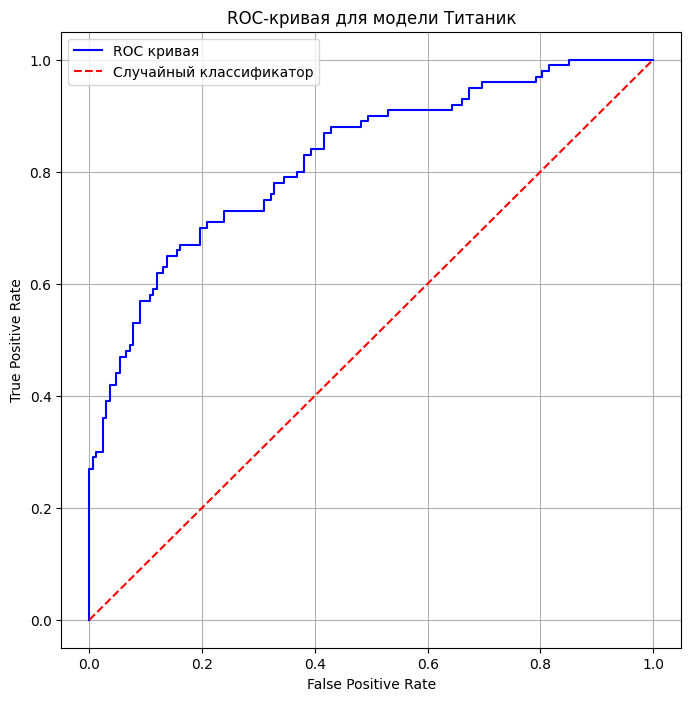

In [18]:
y = 0
x = 0
X = [x]
Y = [y]
for a in comparison_df['Actual']:
    if a == 1:
        y += 1/P
    else:
        x += 1/N
    X.append(x)
    Y.append(y)
# Строим график
plt.figure(figsize=(8, 8))
plt.plot(X, Y, 'b-', label='ROC кривая')
plt.plot([0, 1], [0, 1], 'r--', label='Случайный классификатор')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для модели Титаник')
plt.legend()
plt.grid(True)
plt.show()       
       

      

In [19]:
from tpot import TPOTClassifier
import mlflow
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Создаем и настраиваем TPOT
tpot = TPOTClassifier(
    generations=5,  # количество поколений для оптимизации
    population_size=20,  # размер популяции в каждом поколении
    cv=5,  # количество фолдов для кросс-валидации
    random_state=42,
    verbosity=2,
    n_jobs=-1  # использовать все доступные ядра процессора
)

# Запускаем MLflow эксперимент для отслеживания результатов
with mlflow.start_run(run_name="TPOT_AutoML"):
    # Обучаем TPOT
    tpot.fit(x_train, y_train)
    
    # Получаем предсказания
    y_pred_auto = tpot.predict(x_test)
    y_pred_proba_auto = tpot.predict_proba(x_test)[:, 1]
    
    # Вычисляем метрики
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred_auto),
        'precision': precision_score(y_test, y_pred_auto),
        'recall': recall_score(y_test, y_pred_auto),
        'roc_auc': roc_auc_score(y_test, y_pred_proba_auto)
    }
    
    # Логируем метрики
    mlflow.log_metrics(metrics)
    
    # Сохраняем лучший пайплайн
    mlflow.sklearn.log_model(tpot.fitted_pipeline_, "tpot_best_model")
    
    # Выводим результаты
    print("\nЛучший пайплайн:")
    print(tpot.fitted_pipeline_)
    print("\nМетрики на тестовом наборе:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value:.3f}")

# Построение ROC-кривой для сравнения моделей
plt.figure(figsize=(10, 8))

# ROC-кривая для базовой модели
fpr_base, tpr_base, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr_base, tpr_base, 'b-', label=f'Базовая модель (AUC = {roc_auc_score(y_test, y_pred_proba):.3f})')

# ROC-кривая для AutoML модели
fpr_auto, tpr_auto, _ = roc_curve(y_test, y_pred_proba_auto)
plt.plot(fpr_auto, tpr_auto, 'r-', label=f'AutoML модель (AUC = {metrics["roc_auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Случайный классификатор')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Сравнение ROC-кривых базовой и AutoML моделей')
plt.legend()
plt.grid(True)
plt.show()



ModuleNotFoundError: No module named 'tpot'